# Part2: Extract, Transform, Load

data is taken from https://www.kaggle.com/c/santander-customer-transaction-prediction

In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.

In this notebook we prepare data for analysis.

## Load packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Load data

In [2]:
df_train = pd.read_csv("datasets/train.csv")
df_test = pd.read_csv("datasets/test.csv")

### Prepare dataset for training

In [3]:
#read dataset for training
Y_train = df_train['target']
X_train = df_train.drop(['target', 'ID_code'], axis=1)
print('Original dataset shape %s' % Counter(Y_train))
#read dataset for testing
X_test = df_test.drop(['ID_code'], axis=1)


Original dataset shape Counter({0: 179902, 1: 20098})


In [4]:
#split 'train' dataset for training and validation
X_train_samp ,X_val_samp ,Y_train_samp , Y_val_samp = train_test_split(X_train,Y_train,test_size=0.30,random_state=45)

In [5]:
##over-sample training sample
#print('Original training dataset shape %s' % Counter(Y_train_samp))
#sm = SMOTE(random_state=42, sampling_strategy=0.2, k_neighbors=100)
#X_train_resamp, Y_train_resamp = sm.fit_resample(X_train_samp, Y_train_samp)
#print('Over-sampled trainig dataset shape %s' % Counter(Y_train_resamp))

### Check for outliers

In [6]:
def detect_outlier(data_1,thresh):
    outliers=[]
    threshold=thresh
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            #print ("z_score", z_score)
            outliers.append(y)
    return outliers

In [7]:
##print("Before: ")
##print (X_train_resamp.shape)
##print (X_test.shape)
#outsider=0
#for i in range (200):
#    name = 'var_'+str(i)  
#    if(detect_outlier(X_train_resamp[i],5)):
#        outsider=outsider+1
#        #print (name, detect_outlier(X_train_resamp[i],5))
#        ##remove variables with outliers
#        #X_train_resamp = X_train_resamp.drop([i], axis=1)
#        #X_test = X_test.drop([name], axis=1)
#print("N outsiders: ",outsider)
##print (X_train_resamp.shape)
##print (X_test.shape)

Variables with extrem outliers (with z_score>5) are not observed before resampling, but there are quite many after resampling.
Possible improvement: tune settings for resampling? 

# Remove vars known to be strange


In [8]:
# see https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/83048#486500
for i in range (200):
    if(i==68 or i==12 or i==15 or i==14):
        name = 'var_'+str(i)
        X_test = X_test.drop([name], axis=1)
        X_train = X_train.drop([name], axis=1)
        X_val_samp = X_val_samp.drop([name], axis=1)
        X_train_samp = X_train_samp.drop([name], axis=1)
       # X_train_resamp = X_train_resamp.drop([name], axis=1)

### Normalisation
For DNN we need normalised data


In [9]:
#Standardize features by removing the mean and scaling to unit variance
#sc = StandardScaler()
#sc.fit(X_train_resamp)
#X_train_std = sc.transform(X_train_resamp) #for training
#X_test_std = sc.transform(X_test) #for model evaluation
#X_val_std = sc.transform(X_val_samp) #for sanity checks

#PCA
pca = PCA(n_components='mle', svd_solver='full',whiten=True)
#pca = PCA(n_components=100, svd_solver='randomized',whiten=True)
#pca.fit(X_train_resamp)
pca.fit(X_train)
#X_train_resamp_std = pca.transform(X_train_resamp) #for alternative training
X_test_std = pca.transform(X_test) #for model evaluation
X_val_std = pca.transform(X_val_samp) #for sanity checks

X_train_std = pca.transform(X_train_samp) #for training


In [10]:
#check distributions after normalisations
means_train=[]
stds_train=[]
means_test=[]
stds_test=[]
for j in range (200):
    #print("Loop over N=",len(X_train_std[:j]))
    for i in range (len(X_train_std[:j])):
        means_train.append(X_train_std[i:j].mean())
        stds_train.append(X_train_std[i:j].std())    
        means_test.append(X_test_std[i:j].mean())
        stds_test.append(X_test_std[i:j].std())


/home/anastasia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


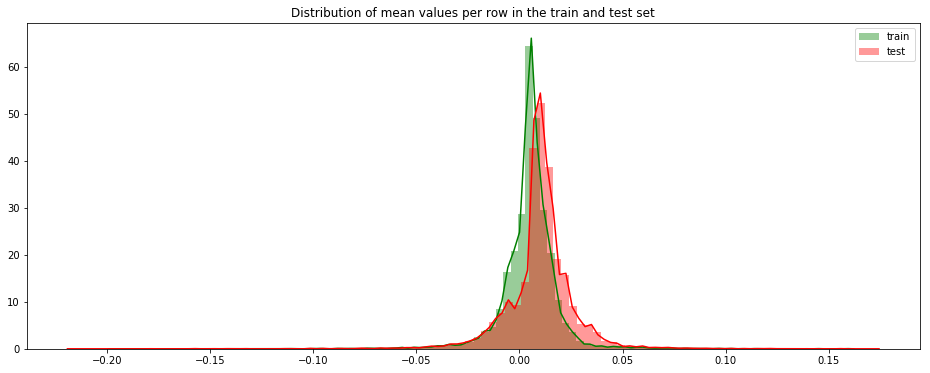

In [11]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(means_train,color="green", kde=True,bins=100, label='train')
sns.distplot(means_test,color="red", kde=True,bins=100, label='test')
plt.legend()
plt.show()


    

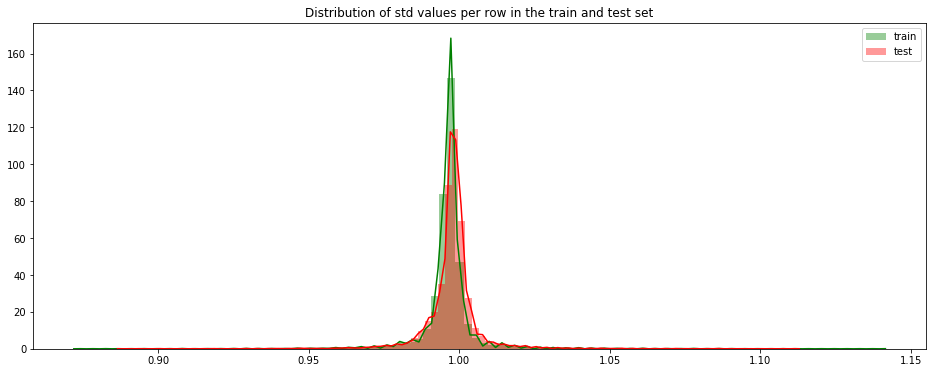

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(stds_train,color="green", kde=True,bins=100, label='train')
sns.distplot(stds_test,color="red", kde=True,bins=100, label='test')
plt.legend()
plt.show()

Mean value is at 0 for both train and test dataset. Standard deviation is at 1.04 also for both. Not ideal, but biased in similar way. Possible improvement: tune settings for normalisation to bring std to 1.0?

## Store datasets
For later usage, store X_train_std, Y_train_resamp for training and X_test_std to create submition

In [13]:
#X_train_std.tofile("X_train_std")
#Y_train_resamp.tofile("Y_train_resamp")
#X_test_std.tofile("X_test_std")
np.save("datasets/X_train_samp_std", X_train_std)
np.save("datasets/Y_train_samp", Y_train_samp)

#np.save("X_train_resamp_std", X_train_resamp_std)
#np.save("Y_train_resamp", Y_train_resamp)

np.save("datasets/X_val_samp_std",X_val_std)
np.save("datasets/Y_val_samp",Y_val_samp)

np.save("datasets/X_test_std", X_test_std)

#np.save("X_train_orig_std", X_train_orig_std)
#np.save("Y_train_orig", Y_train)


#print (X_train_orig_std.shape)
#print (X_train_std.shape)
#print (Y_train_resamp.shape)
#%ls
#print(X_train_std)

In [14]:
#X_train_std2 = np.fromfile("X_train_std")
#print(X_train_std2)

## Conclusion, observations

* dataset is balanced with over-sampling
* drawback of re-sampling: more outliers appeared in dataset
* Mean and standart deviations are normilised: Mean at 0, Std at 1.04

In [15]:
35*72

2520